<a href="https://colab.research.google.com/github/JazzPauw/capstone/blob/main/Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 825.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_6

In [2]:
# This code was created and ran in google colab

%matplotlib inline
import os
import cv2
import seaborn as sns
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

frames_folder = r'/content/images'

model_v8 = YOLO('yolov8n-seg.pt')
model_v9 = YOLO('yolov9e-seg.pt')

def run_segmentation(model, image):
    results = model(image, classes=[0])
    model_image = image.copy()
    for result in results:
        confidences = result.boxes.conf.tolist()
        print(confidences)
        masks = result.masks.xy
        boxes = result.boxes.xyxy.cpu().numpy().astype(int)
        count = len(masks)
        for box, mask, conf in zip(boxes, masks, confidences):
            xmin, ymin, xmax, ymax = box
            x_center = (xmin + xmax) // 2
            y_center = (ymin + ymax) // 2
            new_position = (x_center, y_center)
            model_image = cv2.circle(model_image, new_position, radius=8, color=(255, 0, 0), thickness=-1)
            cv2.putText(model_image, f"{conf:.2f}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        return count, model_image, confidences


# List to hold outputs
outputs = []


for frame_name in os.listdir(frames_folder):
    frame_path = os.path.join(frames_folder, frame_name)
    frame = cv2.imread(frame_path)

    if frame is None:
        continue

    # Run segmentation
    count_v8, image_v8, confidences_v8 = run_segmentation(model_v8, frame)
    count_v9, image_v9, confidences_v9 = run_segmentation(model_v9, frame)

    outputs.append({
            'frame': frame_name,
            'count_v8': count_v8,
            'count_v9': count_v9,
            'confidence_v8': confidences_v8,
            'confidence_v9': confidences_v9,
            'results_v8': image_v8,
            'results_v9': image_v9
        })
print("All frames completed.")

100%|██████████| 6.74M/6.74M [00:00<00:00, 80.2MB/s]


100%|██████████| 117M/117M [00:00<00:00, 128MB/s]



0: 384x640 11 persons, 463.7ms
Speed: 25.6ms preprocess, 463.7ms inference, 89.4ms postprocess per image at shape (1, 3, 384, 640)
[0.8308600187301636, 0.8098235130310059, 0.7390308976173401, 0.7178774476051331, 0.6992682814598083, 0.6991686224937439, 0.6416012048721313, 0.6265872120857239, 0.4813913404941559, 0.30357328057289124, 0.25242939591407776]

0: 384x640 15 persons, 5462.7ms
Speed: 3.7ms preprocess, 5462.7ms inference, 32.2ms postprocess per image at shape (1, 3, 384, 640)
[0.8769140243530273, 0.8324810266494751, 0.807479977607727, 0.7767757773399353, 0.744301974773407, 0.7241566777229309, 0.702691912651062, 0.6429219841957092, 0.6303479075431824, 0.5604681372642517, 0.5435126423835754, 0.5224898457527161, 0.4168241322040558, 0.30466508865356445, 0.28829440474510193]

0: 384x640 5 persons, 204.9ms
Speed: 4.8ms preprocess, 204.9ms inference, 13.7ms postprocess per image at shape (1, 3, 384, 640)
[0.5620009303092957, 0.5453973412513733, 0.5152921676635742, 0.4692738652229309, 0

In [3]:
df_outputs = pd.DataFrame(outputs)
df_outputs['count_difference'] = df_outputs['count_v9'] - df_outputs['count_v8']
filtered_df_outputs = df_outputs[df_outputs['count_difference'] != 0]
print(filtered_df_outputs[['count_v8','count_v9','count_difference']])

     count_v8  count_v9  count_difference
0          11        15                 4
1           5        10                 5
2          12        17                 5
3           5        10                 5
4           6        10                 4
..        ...       ...               ...
129         5         8                 3
130         6        10                 4
131         9        15                 6
132         8        13                 5
133        13        16                 3

[132 rows x 3 columns]


In [4]:
total_cases = len(df_outputs)
total_outliers = len(filtered_df_outputs)
print(f"Total cases: {total_cases}")
print(f"Total outliers: {total_outliers}")
print(f"Percentage discrepencies: {(total_outliers/total_cases)*100}%")
print(f"Average difference: {df_outputs['count_difference'].mean()} persons")

Total cases: 134
Total outliers: 132
Percentage discrepencies: 98.50746268656717%
Average difference: 4.985074626865671 persons


In [5]:
import cv2
def display_outlier_images(index, model):
    outlier_data = df_outputs.iloc[index]
    if model == 8:
        image_array = outlier_data['results_v8']
        print(f"Counted: {outlier_data['count_v8']} people with YoloV8.")
    elif model == 9:
        image_array = outlier_data['results_v9']
        print(f"Counted: {outlier_data['count_v9']} people with YoloV9.")
    else:
        raise ValueError("Invalid model number. Choose 8 or 9.")

    image_array_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_array_rgb)
    plt.title(f'Displaying Yolo {model} result')
    plt.axis('off')
    plt.show()

In [6]:
sorted_df_outputs = filtered_df_outputs.sort_values('count_difference', ascending=False)
print(sorted_df_outputs[['count_v8', 'count_v9', 'count_difference']])

     count_v8  count_v9  count_difference
23          3        13                10
105         5        15                10
36          6        16                10
123         2        12                10
108         4        13                 9
..        ...       ...               ...
69         10        11                 1
75         13        14                 1
103        12        13                 1
5           9        10                 1
78         11        12                 1

[132 rows x 3 columns]


Counted: 3 people with YoloV8.


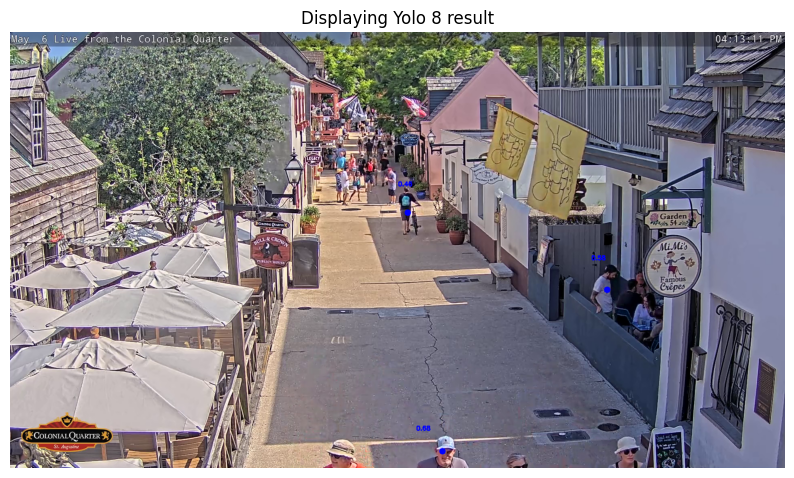

Counted: 13 people with YoloV9.


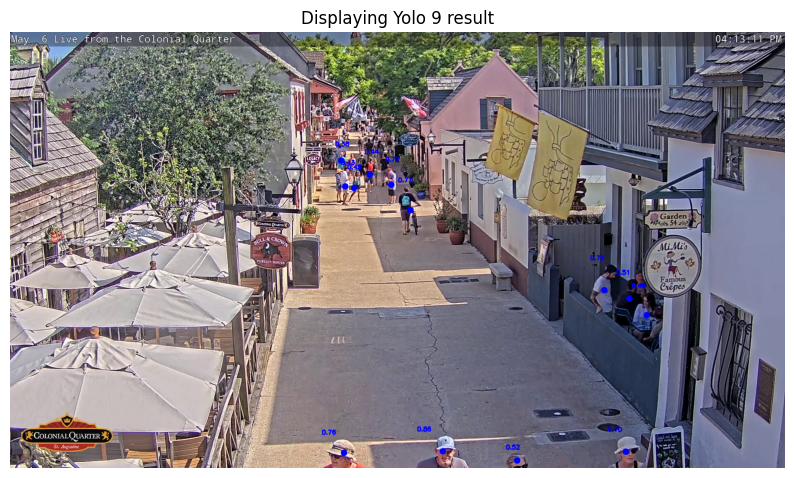

In [7]:
display_outlier_images(23, 8)
display_outlier_images(23, 9)
# We can recognize there's a lot more people than 3 and that 13 is much more accurate

In [8]:
df_outputs['average_confidence_v8'] = df_outputs['confidence_v8'].apply(lambda x: sum(x) / len(x))
df_outputs['average_confidence_v9'] = df_outputs['confidence_v9'].apply(lambda x: sum(x) / len(x))
df_outputs['conf_difference'] = df_outputs['average_confidence_v9'] - df_outputs['average_confidence_v8']
df_outputs[['average_confidence_v8','average_confidence_v9','conf_difference']].head(10)

,average_confidence_v8,average_confidence_v9,conf_difference
0,0.618328,0.624955,0.006627
1,0.469565,0.586695,0.117129
2,0.529844,0.660869,0.131025
3,0.631598,0.597768,-0.033830
4,0.568422,0.671787,0.103365
5,0.540801,0.643510,0.102708
6,0.624336,0.631179,0.006843
7,0.351565,0.568734,0.217169
8,0.521036,0.573262,0.052226
9,0.583541,0.683775,0.100234


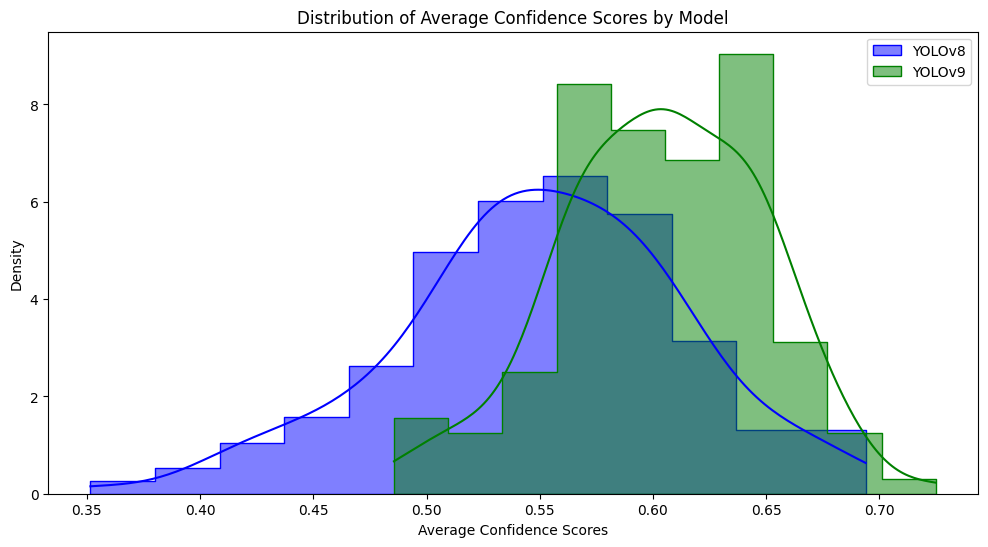

In [9]:
# On average, the yolov9 has higher average confidence scores
plt.figure(figsize=(12, 6))
sns.histplot(df_outputs['average_confidence_v8'], color='blue', label='YOLOv8', kde=True, element='step', stat='density')
sns.histplot(df_outputs['average_confidence_v9'], color='green', label='YOLOv9', kde=True, element='step', stat='density')
plt.xlabel('Average Confidence Scores')
plt.ylabel('Density')
plt.title('Distribution of Average Confidence Scores by Model')
plt.legend()
plt.show()

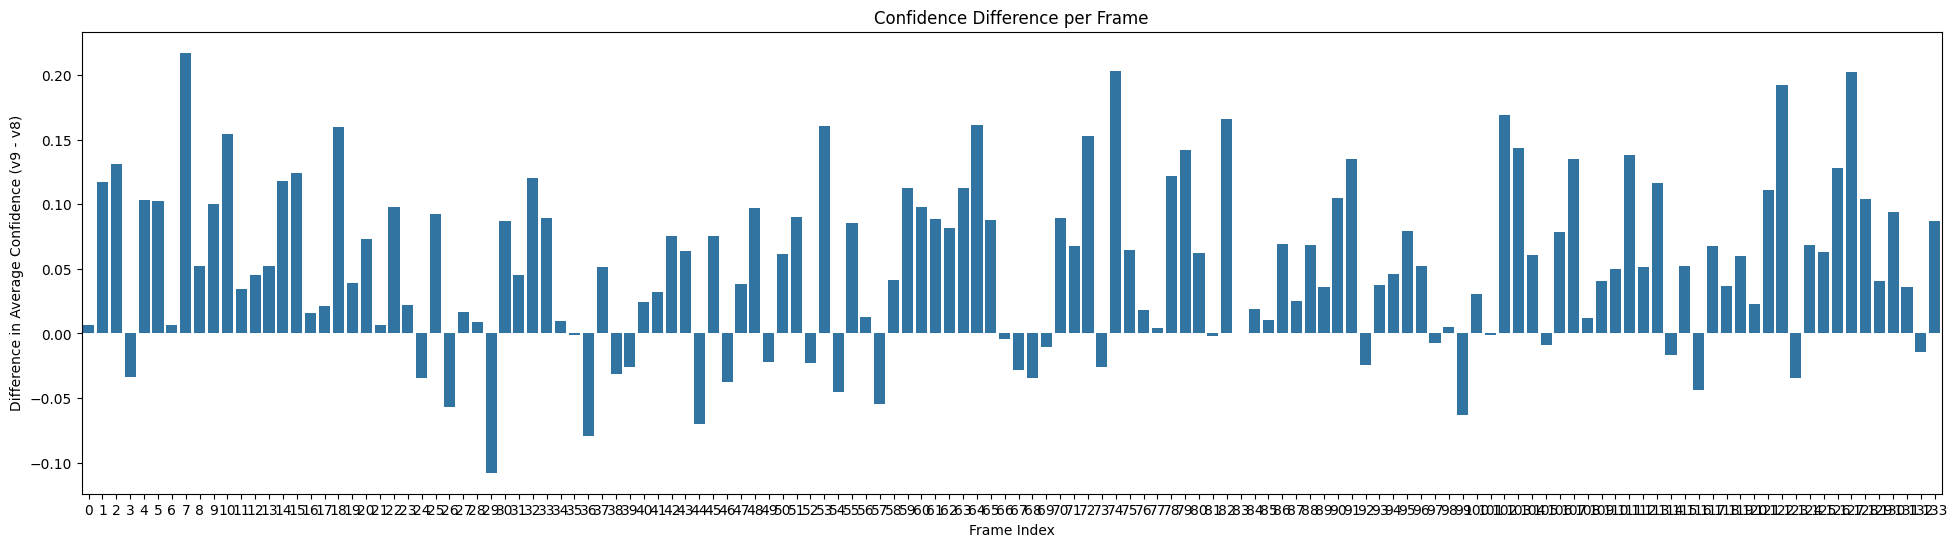

In [12]:
plt.figure(figsize=(24, 6))
sns.barplot(x=df_outputs.index, y='conf_difference', data=df_outputs)
plt.xlabel('Frame Index')
plt.ylabel('Difference in Average Confidence (v9 - v8)')
plt.title('Confidence Difference per Frame')
plt.show()

Counted: 8 people with YoloV8.


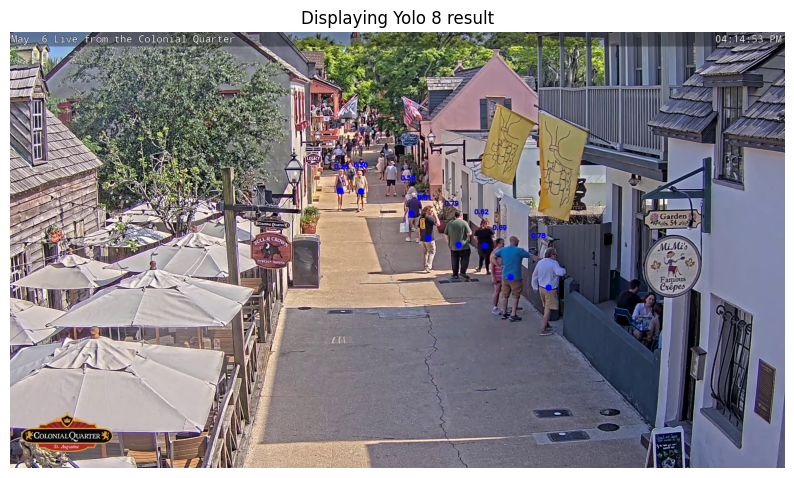

Counted: 13 people with YoloV9.


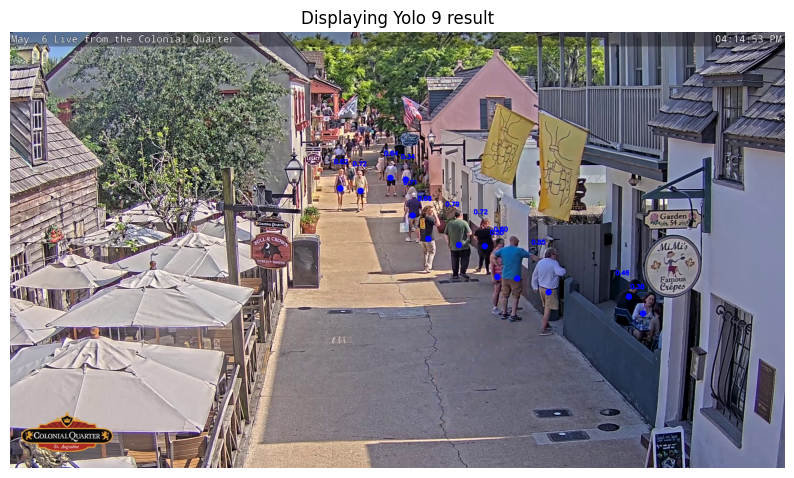

In [13]:
# V9 counts significantly more people but with a lower confidence score on average.
# This means that even if the average confidence score is lower, it may still be yielding greater results than Yolo_v8
display_outlier_images(93, 8)
display_outlier_images(93, 9)

In [ ]:
# We can conclude that Yolov9 is significantly better at detecting persons than Yolov8.